# PCA-Based CNN

This notebook explores the use of PCA combined with CNN. The PCA is applied as the first layer of the CNN and before the convolutional layers.

This model has three stages:
- PCA Dimensionality Reduction
- Convolutional Layer
- Fully connected layer

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import time
import torch.nn.functional as F

from pathlib import Path
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchinfo import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
NUM_CLASSES = 5
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
IMAGE_DATASET_PATH = str(Path().absolute()) + "/dataset"
MANUAL_SEED= 42
NUM_EPOCHS = 200
LEARNING_RATE=0.005
VALID_SIZE=0.1
N_COMPONENTS=50
# Set random seed for reproducibility
np.random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

In [3]:
def checkpoint(model, optimizer, filename):
    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, filename)
    
def resume(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

## Read the dataset
The dataset will contain the labeled data after reading it from the directory. Include the labels but this won't bear weight on feature reduction.

In [128]:
train_transforms = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transforms = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

This uses a custom dataset reader for the dataset. PCA is performed only when retrieving an item. PCA is implemented on each color channel as implementing it on all of the channel at once does not work and just produce a 1:1 copy. This is because the minimum component between the feature and samples is one for all channels combined whereas, individual channels have minimum component somewhere between height and width of image.

In [5]:
class ImageFolderPCA(torchvision.datasets.ImageFolder):
    def __init__(self, root, n_components, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.lazy_loaded_images = {}
        self.n_components = n_components
        
    def __getitem__(self, index):
        path, label = self.samples[index]
        sample = self.loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        pca_sample = self.reduce_features(sample)
#         print("PCA SAMPLE: ", pca_sample, "ORIG: ", sample)
        return pca_sample, label, sample
    
    def pca(self, torchsensor):
        U, S, eigenvectors = torch.pca_lowrank(torchsensor, q=self.n_components)
        projection = torch.matmul(torchsensor, eigenvectors)
        approx = torch.matmul(eigenvectors, projection.T)
        total_var = torch.var(torchsensor)
        total_var_approx = torch.var(approx)
        cumulative_percent_variance = (total_var_approx / total_var) * 100
#         print("cumulative_percent_variance: ", cumulative_percent_variance, total_var_approx, total_var)
        return approx
    
    def reduce_features(self, rgb_data):
        # PCA per channel
        red = rgb_data[0]
        green = rgb_data[1]
        blue = rgb_data[2]
        
        reduced_red = self.pca(red)
        reduced_green = self.pca(green)
        reduced_blue = self.pca(blue)
        
        rgb_tensor = torch.stack((reduced_red, reduced_green, reduced_blue), dim=0)
        
        return rgb_tensor
    
# This doesn't work since it's mixing all of the channel's pixel thus it has a shape of [1, 120000] instead of [200, 200]
        # Reshape RGB data into the format expected by torch.pca_lowrank
#         rgb_data_reshaped = rgb_data.reshape(3 * IMAGE_SIZE[0] * IMAGE_SIZE[1], -1)
# #         torchsensor = rgb_data_reshaped.flip(0)# torch.as_tensor(rgb_data_reshaped.T)
#         torchsensor = torch.as_tensor(rgb_data_reshaped.T)
#         print("rgb_data_reshaped: ", rgb_data_reshaped.shape)
#         print("rgb_data_reshaped.T.shape: ", len(torchsensor[0]))
#         # Perform PCA using torch.pca_lowrank
#         U, S, eigenvectors = torch.pca_lowrank(torchsensor)

#         # Project RGB data onto the principal components
#         pca_result = torch.matmul(torchsensor.T, eigenvectors.T[:, :self.n_components])
# #         pca_result = torch.matmul(torchsensor, eigenvectors.T)
#         pca_result  = torch.matmul(eigenvectors.T[:, :N_COMPONENTS], pca_result.T)
# #         pca_result  = torch.matmul(eigenvectors.T, pca_result.T)
#         print("APPROX: ", pca_result.shape, eigenvectors.shape)
#         total_var = torch.var(torchsensor.T)
#         total_var_approx = torch.var(pca_result.T)
#         cumulative_percent_variance = (total_var_approx / total_var) * 100
#         print("cumulative_percent_variance: ", cumulative_percent_variance)
#         print("---------------------------------")
#         # Reshape the PCA result back to the original shape
# #         pca_result = pca_result.view(*rgb_data.shape[:-1], -1)
#         pca_result = torch.reshape(pca_result[0], (3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
#         return pca_result

# Create custom dataset instance
# train_dataset = ImageFolderPCA(root='dataset/train', transform=train_transforms, n_components=N_COMPONENTS)
# # Create data loader
# data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# len(data_loader)

### Check the reconstructed image

In [6]:
# Create custom dataset instance
train_dataset = ImageFolderPCA(root='dataset/train', transform=train_transforms, n_components=N_COMPONENTS)
# Create data loader
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
len(data_loader)

2110

Show the reconstructed image and each color channel.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 200, 200])


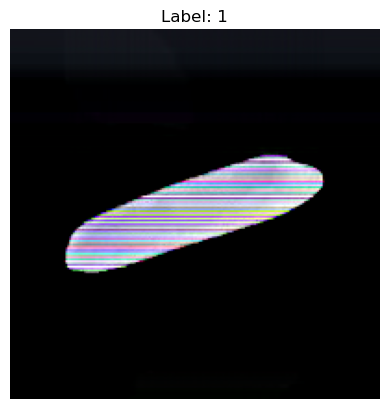

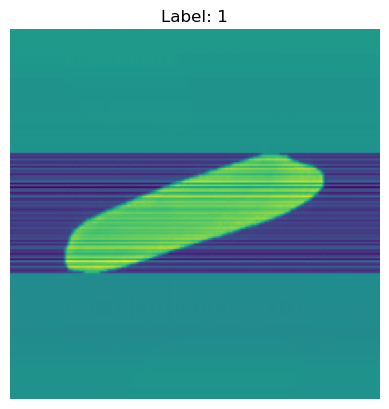

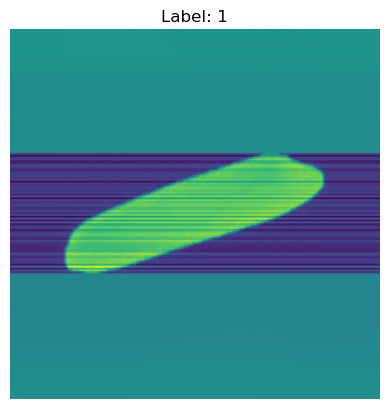

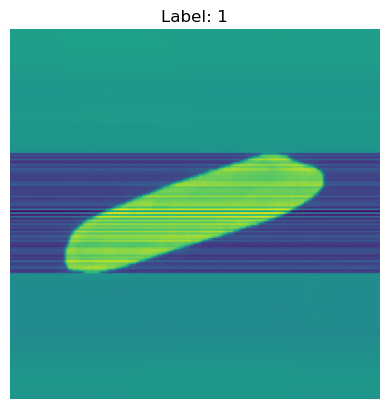

In [7]:
dataiter = iter(data_loader)
images, labels, origs = next(dataiter)
print(images.shape)

for i, img  in enumerate(images):
    temp = img.permute(1,2,0)
    plt.imshow(temp)
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
    plt.show()
    
    plt.imshow(img[0])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
    plt.show()
    
    plt.imshow(img[1])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
    plt.show()
    
    plt.imshow(img[2])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
    plt.show()
    break

In [129]:
train_dataset = ImageFolderPCA(root='dataset/train', transform=train_transforms, n_components=N_COMPONENTS)
test_dataset = ImageFolderPCA(root='dataset/test', transform=test_transforms, n_components=N_COMPONENTS)
valid_dataset = ImageFolderPCA(root='dataset/train', transform=train_transforms, n_components=N_COMPONENTS)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,                                     
    shuffle=False)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(VALID_SIZE * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    sampler=train_sampler
)
    
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE,
    sampler=valid_sampler
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


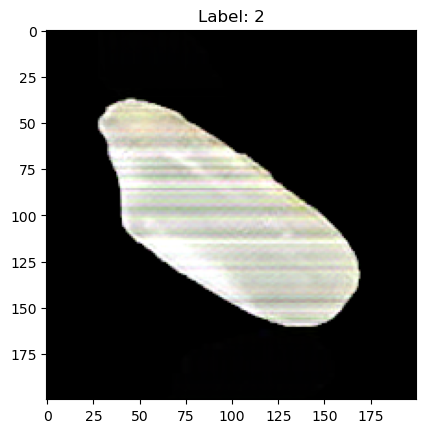

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


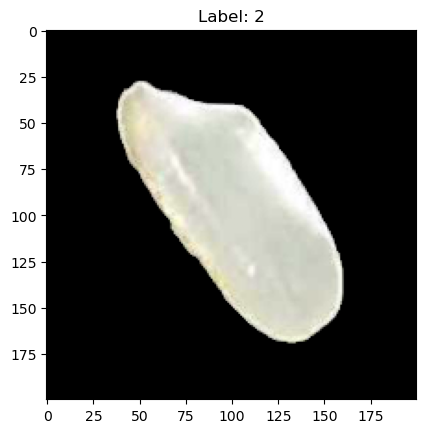

In [10]:
dataiter = iter(data_loader)
images, labels, origs = next(dataiter)

for i, img  in enumerate(images):
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Label: {labels[i]}")
    plt.show()
    plt.title(f"Label: {labels[i]}")
    plt.imshow(origs[i].permute(1,2,0))
    plt.show()
    break

In [106]:
len(train_loader)

1899

## PCAConv2D layer

<p style="color:red">Adding a custom PCA layer in the CNN doesn't work. It only adds computational time for CNN and is prone to out-of-memory error. Instead use PCA outside of the CNN model. Extract the features first then train the model.</p>

In [11]:
class PCAConv2D(nn.Module):
    def __init__ (self, n_components, kernel_size=3, stride=1, padding=0):
        super(PCAConv2D, self).__init__()
        self.n_components = n_components
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.has_displayed = False
        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
#         x_reshaped = x.view(channels, batch_size * height * width)
        x_reshaped = x.detach().cpu().numpy().reshape(-1, 3 * IMAGE_SIZE[0] * IMAGE_SIZE[1])
        print(x_reshaped.shape)
        pca = PCA(n_components=self.n_components, random_state=MANUAL_SEED)
        pca.fit(x_reshaped)
        pca_output = pca.transform(x_reshaped)
        print(pca_output.shape)
        pca_output = torch.from_numpy(pca_output).float().to(x.device).view(batch_size, height, width, channels)
        
#         pca_output = pca_output.permute(0, 3, 1, 2)
        print(pca_output.shape)
        
        if(self.has_displayed == False):
            pca_image = pca_output[0].detach().cpu().numpy()
            print(pca_output.shape)
            print(pca_image.shape)
            pca_image = np.moveaxis(pca_image, 0, -1)
            plt.imshow(pca_image)
            plt.axis('off')
            plt.show()
            self.has_displayed = True
        
        return pca_output

## CNN model

A simple CNN with 2 convolutional layer and 2 fully connected layer. At first, PCA was integrated to the CNN. However, the PCA layer causes out-of-memory error and is compute-itensive.

In [101]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
#         self.conv_computed_size = n_components * num_classes * N_COMPONENTS;
#         self.pca_conv = PCAConv2D(n_components=n_components, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(3, 16, 3, 1, "same")
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(200 * 200 * 4, 10)
        self.fc2 = nn.Linear(10, num_classes)

    # Extract features
    def extract(self, x):
#         x = self.pca_conv(x)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.contiguous().view(-1, 200 * 200 * 4)  # Reshape to [batch_size, 32 * 100 * 100]
        return x
    
    def forward(self, x):
        x = self.extract(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [102]:
model = Net(NUM_CLASSES).to(device)

In [103]:
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 5]                   --
├─Conv2d: 1-1                            [32, 16, 200, 200]        448
├─MaxPool2d: 1-2                         [32, 16, 100, 100]        --
├─Linear: 1-3                            [32, 10]                  1,600,010
├─Linear: 1-4                            [32, 5]                   55
Total params: 1,600,513
Trainable params: 1,600,513
Non-trainable params: 0
Total mult-adds (M): 624.64
Input size (MB): 15.36
Forward/backward pass size (MB): 163.84
Params size (MB): 6.40
Estimated Total Size (MB): 185.61

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum = 0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [118]:
total_step = len(train_loader)
start = time.perf_counter()
best_accuracy = -1
start_epoch = 0
start_step = 0
early_stop_thresh = 3
val_loss_per_epoch = {}
train_loss_per_epoch = {}
train_accuracy_per_epoch = {}
val_accuracy_per_epoch = {}
total_step = len(train_loader)
classes = list(train_dataset.class_to_idx.keys())

if start_epoch > 0:
    resume_epoch = start_epoch - 1
    step_number = "full" if start_step == 1689 else start_step
    print("LOADING MODEL...")
    resume(model, optimizer, f"PCACNN-epoch-{resume_epoch}-full.pth")

for epoch in range(start_epoch, NUM_EPOCHS):
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(NUM_CLASSES)]
    n_class_samples = [0 for i in range(NUM_CLASSES)]
    model.train()
    start_epoch_timer = time.perf_counter()
    train_loss = 0.0
    
    for i, (images, labels, _) in enumerate(train_loader):
        if i < start_step:
            continue
        
        if i == start_step:
            print(f"Starting the training process at {i} step, epoch {epoch}...")
        
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for y in range(labels.size(dim=0)):
            label = labels[y]
            pred = predicted[y]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (i + 1) % 200 == 0:
            end_batch_timer = time.perf_counter()
#             checkpoint(model, optimizer, f"VGG-epoch-{epoch}-{i}.pth")
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Seconds per 600 images: {}'.format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(), (end_batch_timer - start_epoch_timer)))
    train_loss /= len(train_loader.dataset)
    
    if start_step <= 0:
        acc = 100.0 * n_correct / n_samples
        end_epoch_timer = time.perf_counter()
        train_accuracy_per_epoch[epoch] = acc
        checkpoint(model, optimizer, f"PCACNN-epoch-{epoch}-full.pth")
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Accuracy of the network: {acc} %, Epoch Training Time: {end_epoch_timer - start_epoch_timer}')

        for i in range(NUM_CLASSES):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Accuracy of {classes[i]} for training: {acc} %. Train Loss {train_loss}')
        print("------------------------------------------------------------")
            
# Validation
# No validation at the moment.
    model.eval()
    with torch.no_grad():
        print(f"VALIDATING THE MODEL FOR EPOCH {epoch + 1}")
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels, _ in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            del images, labels, outputs
        val_loss /= len(valid_loader.dataset)
        
        acc = correct / total
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * acc)) 
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss}, Val Loss: {val_loss}. TIME: {end_epoch_timer - start_epoch_timer} seconds")
        
        train_loss_per_epoch[epoch] = train_loss
        val_loss_per_epoch[epoch] = val_loss
        val_accuracy_per_epoch[epoch] = acc
        # Early stopping
        if acc > best_accuracy:
            print("BEST ACCURACY ", acc)
            best_accuracy = acc
            best_epoch = epoch
            checkpoint(model, optimizer, "PCACNN_best_model.pth")
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break  # terminate the training loop
        print("------------------------------------------------------------")
end = time.perf_counter()
print(f'{end - start} seconds')

Starting the training process at 0 step, epoch 0...
Epoch [1/200], Step [200/1899], Loss: 1.6083, Seconds per 600 images: 87.86791989999983
Epoch [1/200], Step [400/1899], Loss: 1.6126, Seconds per 600 images: 178.51368750000074
Epoch [1/200], Step [600/1899], Loss: 1.6213, Seconds per 600 images: 274.7911540999994
Epoch [1/200], Step [800/1899], Loss: 1.6154, Seconds per 600 images: 366.80943970000044
Epoch [1/200], Step [1000/1899], Loss: 1.6116, Seconds per 600 images: 455.0836995999998
Epoch [1/200], Step [1200/1899], Loss: 1.6100, Seconds per 600 images: 543.0005715000007
Epoch [1/200], Step [1400/1899], Loss: 1.6073, Seconds per 600 images: 631.2807737000003
Epoch [1/200], Step [1600/1899], Loss: 1.6084, Seconds per 600 images: 717.5150211
Epoch [1/200], Step [1800/1899], Loss: 1.6126, Seconds per 600 images: 803.5611196000009
Epoch [1/200]: Accuracy of the network: 20.011522633744857 %, Epoch Training Time: 845.967079
Epoch [1/200]: Accuracy of Arborio for training: 17.711843511

Accuracy of the network on the 5000 validation images: 20.177777777777777 %
Epoch [5/200], Train Loss: 0.04528870672473201, Val Loss: 0.0050309239369851575. TIME: 834.9319856000002 seconds
BEST ACCURACY  0.20177777777777778
------------------------------------------------------------
Starting the training process at 0 step, epoch 5...
Epoch [6/200], Step [200/1899], Loss: 1.6090, Seconds per 600 images: 87.61646190000101
Epoch [6/200], Step [400/1899], Loss: 1.6161, Seconds per 600 images: 175.32275010000012
Epoch [6/200], Step [600/1899], Loss: 1.6105, Seconds per 600 images: 263.11908210000183
Epoch [6/200], Step [800/1899], Loss: 1.6092, Seconds per 600 images: 350.80218389999936
Epoch [6/200], Step [1000/1899], Loss: 1.6091, Seconds per 600 images: 438.36667490000036
Epoch [6/200], Step [1200/1899], Loss: 1.6092, Seconds per 600 images: 526.0369530999997
Epoch [6/200], Step [1400/1899], Loss: 1.6126, Seconds per 600 images: 613.9924601000021
Epoch [6/200], Step [1600/1899], Loss: 1

## Adam Optimized Model Validation and Accuracy Loss

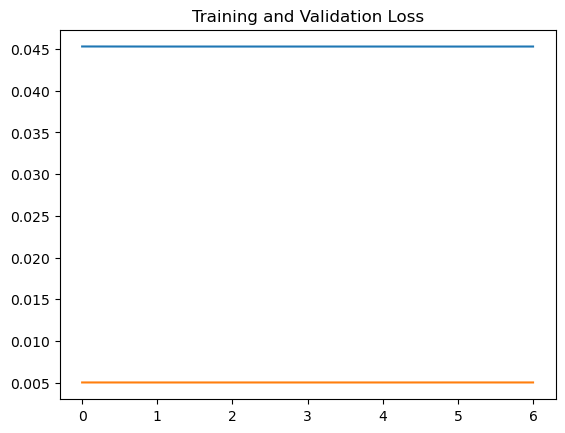

In [114]:
plt.plot(list(train_loss_per_epoch.keys()), list(train_loss_per_epoch.values()), label='Training Loss')
plt.plot(list(val_loss_per_epoch.keys()), list(val_loss_per_epoch.values()), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()

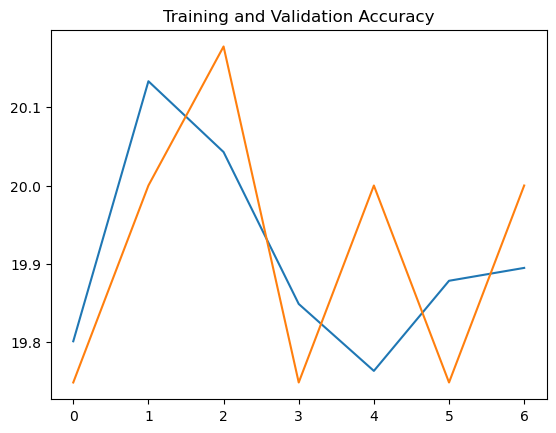

In [115]:
plt.plot(list(train_accuracy_per_epoch.keys()), list(train_accuracy_per_epoch.values()), label='Training Loss')
plt.plot(list(val_accuracy_per_epoch.keys()), [x * 100 for x in list(val_accuracy_per_epoch.values())], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.show()

## SGD CNN model

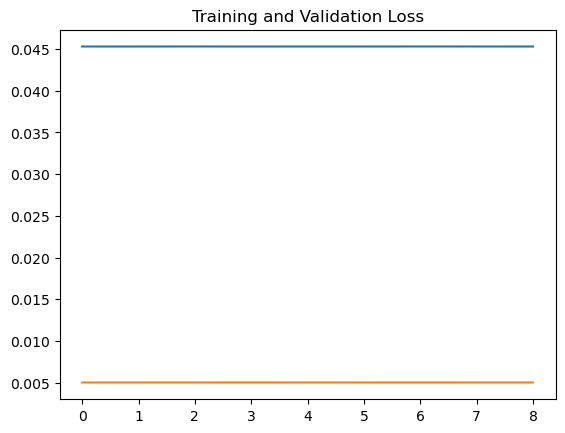

In [119]:
plt.plot(list(train_loss_per_epoch.keys()), list(train_loss_per_epoch.values()), label='Training Loss')
plt.plot(list(val_loss_per_epoch.keys()), list(val_loss_per_epoch.values()), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()

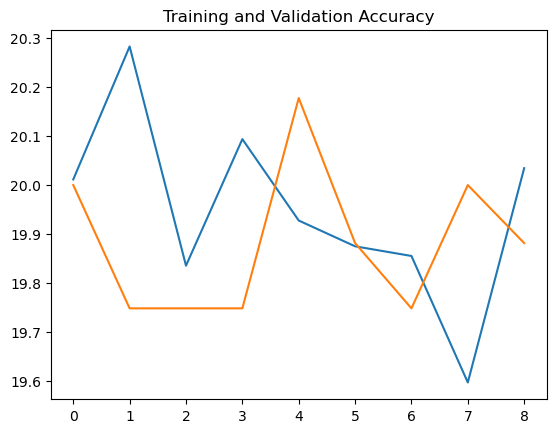

In [120]:
plt.plot(list(train_accuracy_per_epoch.keys()), list(train_accuracy_per_epoch.values()), label='Training Loss')
plt.plot(list(val_accuracy_per_epoch.keys()), [x * 100 for x in list(val_accuracy_per_epoch.values())], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.show()

## Best Model

Test the best model on the test data and record the accuracy and loss per batch

In [130]:
resume(model, optimizer, f"PCACNN_best_model.pth")

model.eval()
per_batch_accuracy = {}
per_batch_loss = {}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(NUM_CLASSES)]
    n_class_samples = [0 for i in range(NUM_CLASSES)]
    val_loss = 0.0
    for i, (images, labels, orig) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
#         max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        per_batch_accuracy[i] = (predicted == labels).sum().item() / labels.size(0)
        per_batch_loss[i] = loss.item()
        
        for i in range(labels.size(dim=0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    for i in range(NUM_CLASSES):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

# with torch.no_grad():
#     model.eval()
#     for i, data in enumerate(test_loader):
#         images = data.to(device)
#         outputs = autoencoder(images)
#         loss = criterion(outputs, images)  # Reconstruction loss
#         val_loss += loss.item()
#     val_loss /= len(ae_validation_loader.dataset)
#     print(f"LOSS FOR TEST DATA: {val_loss:7f}")

Accuracy of the network: 20.0 %
Accuracy of Arborio: 0.0 %
Accuracy of Basmati: 0.0 %
Accuracy of Ipsala: 0.0 %
Accuracy of Jasmine: 0.0 %
Accuracy of Karacadag: 100.0 %


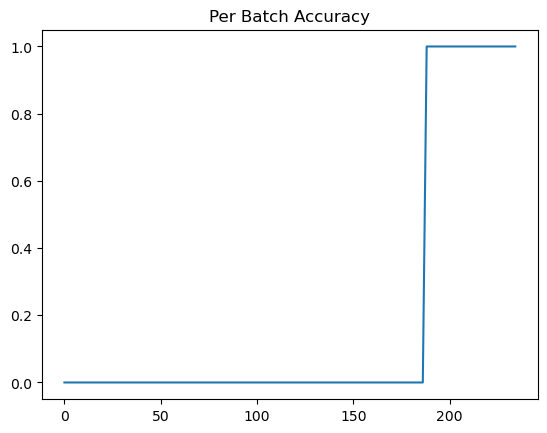

In [131]:
per_batch_accuracy
plt.plot(list(per_batch_accuracy.keys()), list(per_batch_accuracy.values()), label='Training Loss')
plt.title('Per Batch Accuracy')
plt.show() 

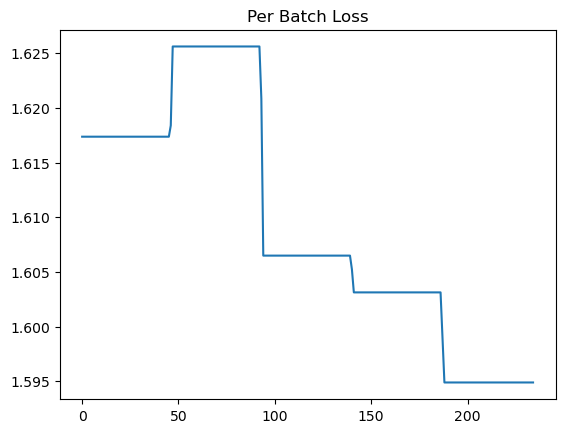

In [132]:
per_batch_accuracy
plt.plot(list(per_batch_loss.keys()), list(per_batch_loss.values()), label='Training Loss')
plt.title('Per Batch Loss')
plt.show()